In [1]:
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download -d pcbreviglieri/smart-grid-stability

100% 6.30M/6.30M [00:00<00:00, 65.7MB/s]
100% 6.30M/6.30M [00:00<00:00, 65.5MB/s]


In [3]:
! unzip /content/smart-grid-stability.zip

Archive:  /content/smart-grid-stability.zip
  inflating: smart_grid_stability_augmented.csv  


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm 
import seaborn as sn
from sklearn import metrics, preprocessing, model_selection

# Read the Data

In [5]:
dataset = pd.read_csv('/content/smart_grid_stability_augmented.csv')
dataset 

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,unstable


In [6]:
# drop the stab column
dataset.drop(columns=['stab'],inplace=True)

In [7]:
# show the dataset information 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stabf   60000 non-null  object 
dtypes: float64(12), object(1)
memory usage: 6.0+ MB


# Preprocessing the Dataset 

In [8]:
# drop the na values 
dataset.dropna(inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 59999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stabf   60000 non-null  object 
dtypes: float64(12), object(1)
memory usage: 6.4+ MB


In [9]:
dataset

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,unstable


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb51783b090>,
      dtype=object)

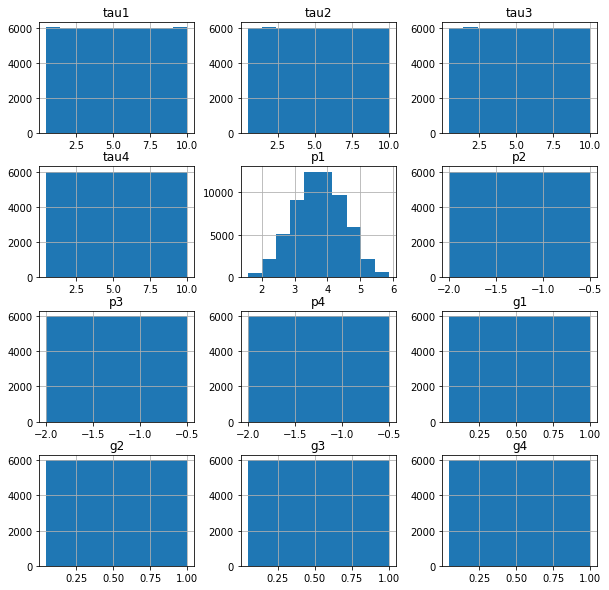

In [10]:
# plot the histogram 
dataset.hist(figsize=(10,10))

In [11]:
dataset.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982


In [12]:
dataset

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,unstable


In [13]:
dataset.iloc[0]

tau1      2.95906
tau2     3.079885
tau3     8.381025
tau4     9.780754
p1       3.763085
p2      -0.782604
p3      -1.257395
p4      -1.723086
g1       0.650456
g2       0.859578
g3       0.887445
g4       0.958034
stabf    unstable
Name: 0, dtype: object

In [14]:

dataset.stabf=dataset.stabf.factorize()[0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb516886d50>,
      dtype=object)

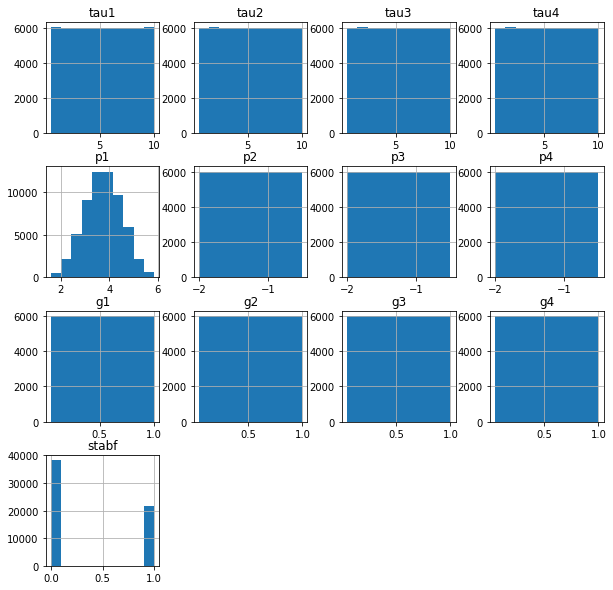

In [15]:
# plot the histogram 
dataset.hist(figsize=(10,10))

In [16]:
new_dataset=dataset[dataset.stabf==1].iloc[:5000,:]
new_dataset = new_dataset.append(dataset[dataset.stabf==0].sample(n=len(new_dataset.stabf)))
new_dataset

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1
5,6.999209,9.109247,3.784066,4.267788,4.429669,-1.857139,-0.670397,-1.902133,0.261793,0.077930,0.542884,0.469931,1
8,4.689852,4.007747,1.478573,3.733787,4.041300,-1.410344,-1.238204,-1.392751,0.269708,0.250364,0.164941,0.482439,1
10,5.930110,6.730873,6.245138,0.533288,2.327092,-0.702501,-1.116920,-0.507671,0.239816,0.563110,0.164461,0.753701,1
12,1.616787,2.939228,0.819791,4.191804,3.752282,-1.484885,-1.280581,-0.986816,0.899698,0.866546,0.303921,0.077610,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42608,2.980547,9.007814,3.339986,5.300352,5.282170,-1.423772,-1.974252,-1.884146,0.498018,0.919080,0.544648,0.822373,0
10856,4.529769,7.756557,3.445857,3.998585,5.292864,-1.489017,-1.969556,-1.834291,0.620844,0.773736,0.057813,0.261780,0
36232,7.350049,3.298612,9.983822,5.390442,3.154415,-1.393176,-1.113198,-0.648041,0.258870,0.832154,0.751338,0.590096,0
43230,9.136937,9.139493,1.908408,3.985057,3.056795,-1.837689,-0.664664,-0.554441,0.332249,0.720667,0.669428,0.498313,0


In [17]:
# split the data to features and labels 
x=new_dataset.iloc[:,:-1]
y=new_dataset.iloc[:,-1]

In [18]:
# scale the feature values between 0,1
min_max_preprocess =preprocessing.StandardScaler()
min_max_preprocess.fit(x)
x_norm=min_max_preprocess.transform(x)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb515d09590>,
      dtype=object)

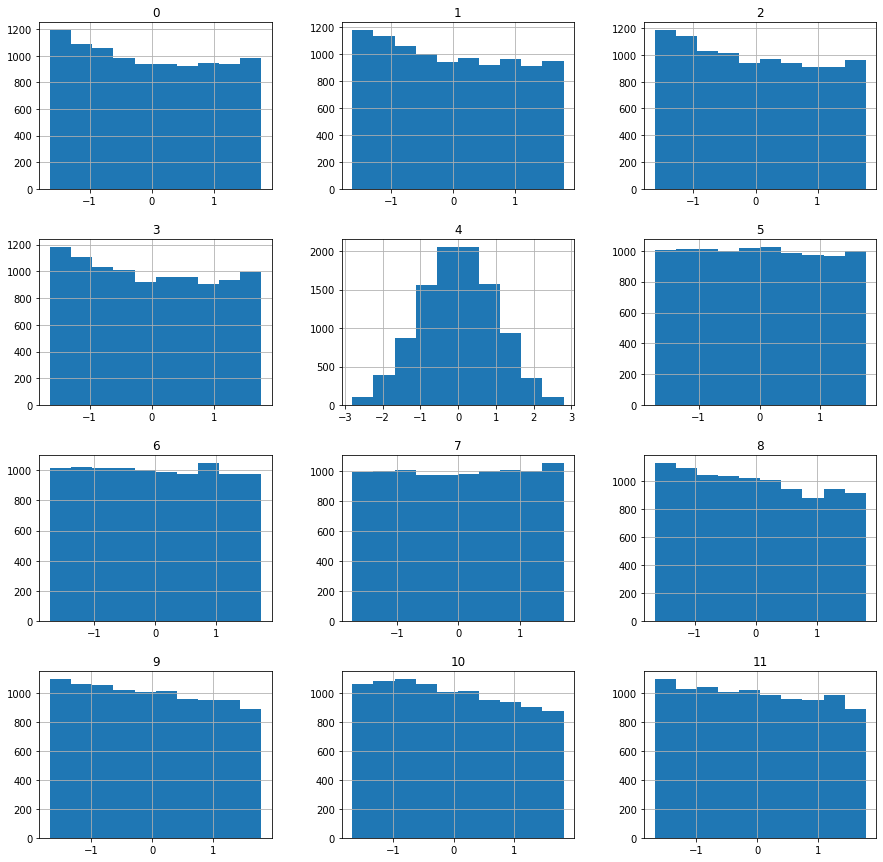

In [19]:
pd.DataFrame(x_norm).hist(figsize=(15,15))

(array([5000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

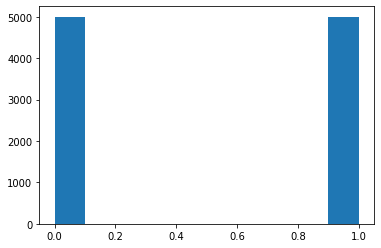

In [20]:
plt.hist(y)

# Spilt the Data to Train & Test 

In [21]:
x_train,x_test,y_train,y_test = model_selection.train_test_split(x_norm,y,test_size=0.1,random_state=42,stratify=y)

# Create the Data Pipeline

In [22]:
# creat the data pipeline
def data_pipeline(x,y,batch_size=32):
    # insert the data to the data pipeline
    data=tf.data.Dataset.from_tensor_slices((x,y))
    data=data.shuffle(50000)# shuffle the data
    data=data.batch(batch_size)# creat the batch
    data=data.prefetch(tf.data.AUTOTUNE)# run the data processing and training in parallel 
    return data

In [23]:
# create the train pipeline 
train_dataset=data_pipeline(x_train,y_train)
# create the test pipeline
test_dataset=data_pipeline(x_test,y_test)

In [24]:
# get the first batch of data from the train pipeline 
for x,y in train_dataset.take(1):
    print(x)
    print(y)

tf.Tensor(
[[-1.05302130e+00  7.93522363e-01 -5.80766358e-01 -5.45427112e-01
  -3.00097200e-01  7.41573628e-01 -2.93238753e-01  7.43873214e-02
  -6.58349740e-01 -7.46147190e-01  1.56078542e+00 -5.89412400e-01]
 [ 6.20694699e-02 -1.31851744e+00  1.39944869e-01  1.78484828e-01
   4.14099793e-01 -1.10331416e+00 -1.16833332e+00  1.53753673e+00
  -1.03709124e+00  9.99611982e-01 -7.96618845e-01 -5.20015939e-01]
 [-7.50688446e-01  1.50734043e+00 -5.62204916e-01 -6.45560606e-01
   7.20373446e-01 -1.40993963e+00 -2.36894106e-01  3.87915267e-01
  -5.45693393e-01 -9.79684649e-01 -6.08881582e-01 -1.18512818e+00]
 [-7.25755481e-01 -4.67711047e-01 -6.78124817e-01  1.27152311e+00
   4.57548072e-01 -7.34543259e-01  4.70806311e-01 -5.29718753e-01
  -4.93158648e-01 -1.75323908e-01  8.64523210e-01 -1.54881520e-01]
 [ 7.02695549e-01  1.44644069e+00  1.73518630e+00 -4.59508190e-01
  -1.09955639e+00  7.12812661e-01  7.62633001e-01  4.37095424e-01
   1.78125240e-01 -3.94037295e-01 -3.45313443e-01  1.09699552

# Model

In [25]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model,self).__init__()
        self.D1=tf.keras.layers.Dense(32,activation=tf.nn.leaky_relu)
        self.D1_dropout=tf.keras.layers.Dropout(0.3)
        self.D2=tf.keras.layers.Dense(64,activation=tf.nn.leaky_relu)
        self.D2_dropout=tf.keras.layers.Dropout(0.3)
        self.D3=tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)
        self.D3_dropout=tf.keras.layers.Dropout(0.3)
        self.D4=tf.keras.layers.Dense(64,activation=tf.nn.leaky_relu)
        self.D4_dropout=tf.keras.layers.Dropout(0.3)
        self.out=tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    def call(self,x ):
        x=self.D1(x)
        x=self.D1_dropout(x)
        x=self.D2(x)
        x=self.D2_dropout(x)
        x=self.D3(x)
        x=self.D3_dropout(x)
        x=self.D4(x)
        x=self.D4_dropout(x)
        out = self.out(x)
        return out


In [26]:
model=Model()
model.build(input_shape=(None,12))

In [27]:
# compile the model an using adam optimizer with Categorical crossentropy cost function
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['acc'],
)
# train the model with batch_size=32,for 100 epochs
model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
282/282 [==============================] - 6s 4ms/step - loss: 0.4772 - acc: 0.7651 - val_loss: 0.3607 - val_acc: 0.8320
Epoch 2/20
282/282 [==============================] - 1s 3ms/step - loss: 0.4006 - acc: 0.8128 - val_loss: 0.3153 - val_acc: 0.8570
Epoch 3/20
282/282 [==============================] - 1s 4ms/step - loss: 0.3698 - acc: 0.8296 - val_loss: 0.2833 - val_acc: 0.8860
Epoch 4/20
282/282 [==============================] - 2s 5ms/step - loss: 0.3416 - acc: 0.8476 - val_loss: 0.2659 - val_acc: 0.9040
Epoch 5/20
282/282 [==============================] - 2s 6ms/step - loss: 0.3220 - acc: 0.8571 - val_loss: 0.2413 - val_acc: 0.8980
Epoch 6/20
282/282 [==============================] - 2s 6ms/step - loss: 0.3020 - acc: 0.8660 - val_loss: 0.2207 - val_acc: 0.9120
Epoch 7/20
282/282 [==============================] - 2s 5ms/step - loss: 0.2960 - acc: 0.8691 - val_loss: 0.2109 - val_acc: 0.9180
Epoch 8/20
282/282 [==============================] - 2s 6ms/step - loss: 0.

# Model Evaluation 

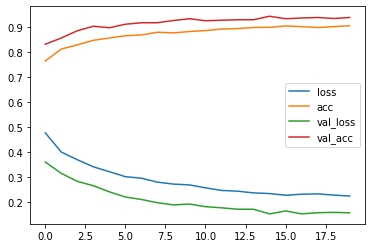

In [28]:
pd.DataFrame(model.history.history).plot()

In [29]:
preds=np.array([])
ys=np.array([])
for x,y in tqdm.tqdm(test_dataset):
    pred = model.predict(x)
    preds=np.append(preds,pred)
  
    ys=np.append(ys,y)
    
    
    
    

100%|██████████| 32/32 [00:01<00:00, 25.30it/s]


In [30]:
 preds = preds>0.5
 preds=preds.astype(int)

accuracy_score: 0.939
precision_score: 0.9434343434343434
recall_score: 0.934
f1_score: 0.9386934673366835


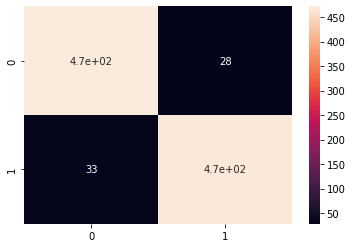

In [31]:
accuracy_score=metrics.accuracy_score(y_true=ys,y_pred=preds)
precision_score=metrics.precision_score(ys,preds)
recall_score=metrics.recall_score(ys,preds,)
f1_score=metrics.f1_score(ys,preds)
confion_metrix=metrics.confusion_matrix(ys,preds)
print('accuracy_score:',accuracy_score)
print('precision_score:',precision_score)
print('recall_score:',recall_score)
print('f1_score:',f1_score)

sn.heatmap(confion_metrix,annot=True)
